# READ README.MD FOR OBSERVATIONS ON WHAT WAS TRIED

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization
from keras import Sequential,models
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau,CSVLogger,EarlyStopping
import os
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,RMSprop
import cv2
from sklearn import metrics,preprocessing
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import pickle

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

main_dict = {
    'filenames': [],
    'labels' :[],
    'data': []
}

for filename in ['/media/yodenharsh/Crucial P3/Research/cifar-10-batches-py/data_batch_' + str(x) for x in range(1,6)]:
    batch = unpickle(filename)
    main_dict['filenames'].extend(batch[b'filenames'])
    main_dict['data'].extend(batch[b'data'])
    main_dict['labels'].extend(batch[b'labels'])

In [3]:
# Check keys

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

unpickle('/media/yodenharsh/Crucial P3/Research/cifar-10-batches-py/data_batch_1').keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [28]:
for i in main_dict.items():
    print(type(i))

<class 'tuple'>
<class 'tuple'>
<class 'tuple'>


Train test split

Splitting test into validation again

In [7]:
X_train, X_test, y_train, y_test = train_test_split(main_dict['data'],main_dict['labels'],test_size=0.2,random_state=1337)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test, test_size=0.5,random_state=1337)

Making model

In [42]:
model = Sequential()

# First Convolutional Layer
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Third Convolutional Layer
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_regularizer=l2(0.001)))

optimizer = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_48 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_49 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                      

Adding callbacks

In [43]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
csv_logger = CSVLogger(filename="./epochs.csv")
early_stopping = EarlyStopping(patience=10,mode="min",monitor="val_loss")


Organizing splits to fit into model

In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

X_train = X_train.reshape(-1, 32, 32, 3)
X_val = X_val.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

print(X_test.shape)
print(y_test.shape)

(5000, 32, 32, 3)
(5000, 10)


Training

In [45]:
history = model.fit(X_train,y_train,
                    epochs=60,
                    batch_size=64,
                    validation_data=(X_val,y_val),use_multiprocessing=True,callbacks=[reduce_lr,csv_logger,early_stopping],workers=2)

Epoch 1/60


2023-11-05 12:47:36.694503: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 12s 15ms/step - loss: 3.0319 - accuracy: 0.3347 - val_loss: 1.9944 - val_accuracy: 0.3936 - lr: 0.0100
Epoch 2/60
625/625 [==============================] - 9s 14ms/step - loss: 1.8779 - accuracy: 0.4401 - val_loss: 2.5572 - val_accuracy: 0.2402 - lr: 0.0100
Epoch 3/60
625/625 [==============================] - 8s 12ms/step - loss: 1.8202 - accuracy: 0.4599 - val_loss: 2.1384 - val_accuracy: 0.3852 - lr: 0.0100
Epoch 4/60
625/625 [==============================] - 8s 13ms/step - loss: 1.7956 - accuracy: 0.4696 - val_loss: 1.7118 - val_accuracy: 0.5034 - lr: 0.0100
Epoch 5/60
625/625 [==============================] - 9s 14ms/step - loss: 1.7833 - accuracy: 0.4696 - val_loss: 1.8306 - val_accuracy: 0.4568 - lr: 0.0100
Epoch 6/60
625/625 [==============================] - 8s 13ms/step - loss: 1.7562 - accuracy: 0.4752 - val_loss: 2.1008 - val_accuracy: 0.4046 - lr: 0.0100
Epoch 7/60
625/625 [==============================] - 8s 13ms/step - loss:

In [46]:
print("Accuracy = {:2f} %".format(model.evaluate(x=X_test,y=y_test)[1] * 100))

157/157 [==============================] - 1s 3ms/step - loss: 0.9933 - accuracy: 0.6792
Accuracy = 67.919999 %


Plotting loss and accuracy curves

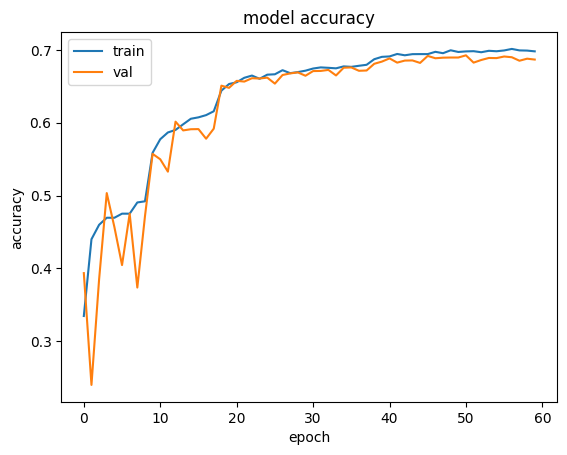

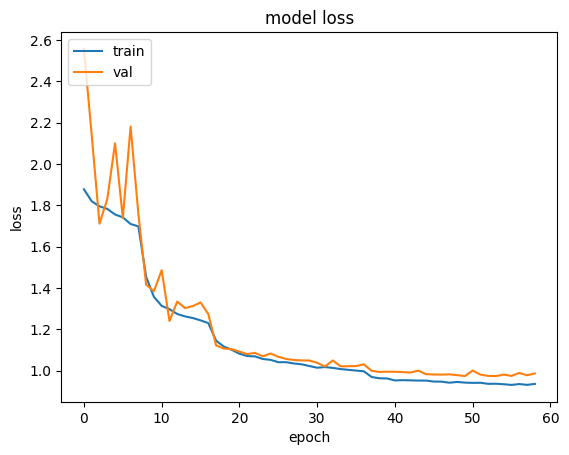

In [47]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Getting y_pred for predictions

In [61]:
y_pred = model.predict(X_test)
np.argmax(y_pred > 0.5,axis=1)


157/157 [==============================] - 0s 2ms/step


array([8, 8, 3, ..., 3, 0, 8])

Generating metrics

              precision    recall  f1-score   support

           0       0.26      0.80      0.39       474
           1       0.86      0.75      0.80       487
           2       0.75      0.33      0.46       503
           3       0.60      0.22      0.32       490
           4       0.68      0.62      0.65       477
           5       0.66      0.53      0.59       497
           6       0.74      0.74      0.74       496
           7       0.83      0.63      0.71       531
           8       0.86      0.79      0.82       524
           9       0.78      0.76      0.77       521

    accuracy                           0.62      5000
   macro avg       0.70      0.62      0.63      5000
weighted avg       0.71      0.62      0.63      5000



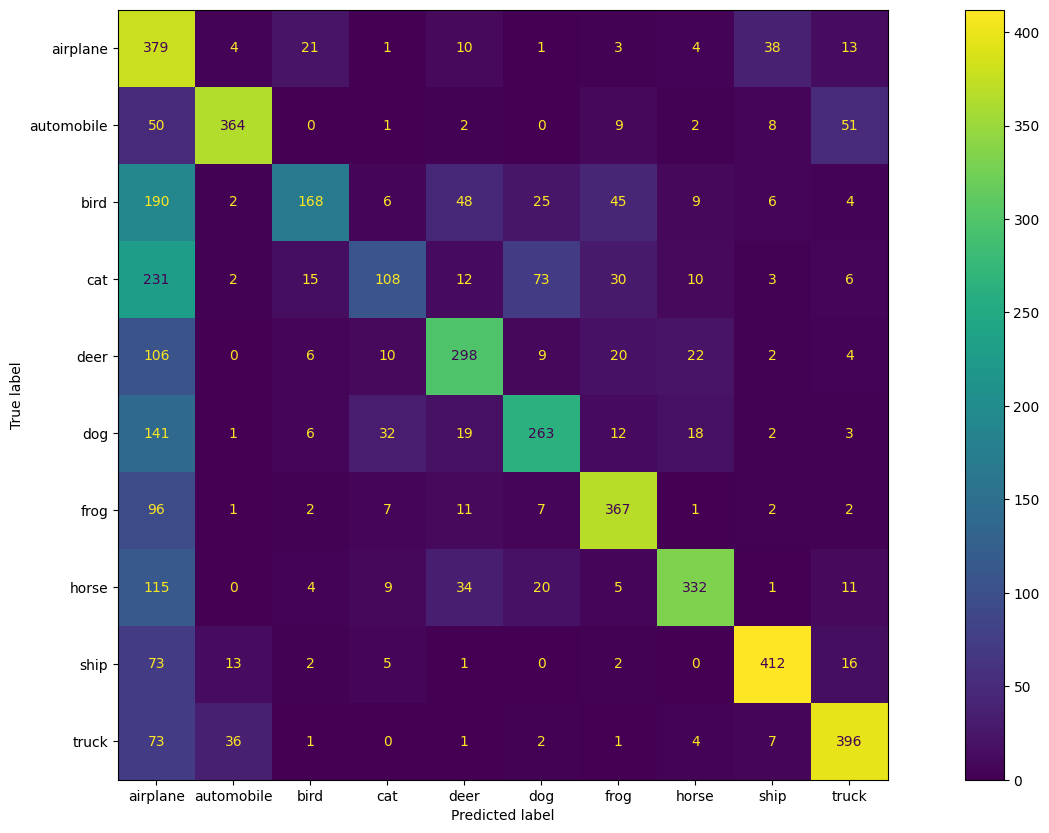

In [73]:
print(metrics.classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred > 0.5,axis=1)))

cm = metrics.ConfusionMatrixDisplay(confusion_matrix=metrics.confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred > 0.5,axis=1)),
                                    display_labels=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck'])
  
fig, ax = plt.subplots(figsize=(20,10))
cm.plot(ax=ax)

plt.show()

Saving model

In [74]:
model.save('model.keras')# Define the path to your "Moderate demented" images